In [3]:
import albumentations as A
from functools import partial
from ultralytics import YOLO
from ultralytics.models.yolo.detect.train import DetectionTrainer
from ultralytics.data.augment import Albumentations as UltralyticsAlbumentations
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
def bbox(box, label="", color="red", ax=None):
    x = [box[0], box[0], box[2], box[2], box[0]]
    y = [box[1], box[3], box[3], box[1], box[1]]
    if ax:
        draw_obj = ax
    else:
        draw_obj = plt    
    draw_obj.plot(x, y, color=color, linewidth=1)     
    draw_obj.text(box[0] + 2, box[1], label, fontsize=10, color=color, 
                  verticalalignment='bottom', horizontalalignment='left')

# Создаем датасет для обучения и валидации

In [5]:
def set_seed(seed_value):
    """Фиксирует зерно для воспроизводимости."""
    random.seed(seed_value)
    np.random.seed(seed_value)


def prepare_yolo_dataset(
    original_data_dir,
    yolo_labels_dir,
    output_base_dir,
    validation_split=0.2,
    class_names_map=None,
    random_seed=42
):
    """
    Подготавливает структуру датасета YOLOv8 (только train/val) из
    исходной папки с изображениями и сконвертированных YOLO-аннотаций.

    Args:
        original_data_dir (str): Путь к директории, содержащей все изображения.
        yolo_labels_dir (str): Путь к директории, содержащей сконвертированные YOLO (.txt) аннотации.
        output_base_dir (str): Корневая директория, где будет создан датасет YOLOv8.
        validation_split (float): Доля данных, которая будет использоваться для валидации.
        class_names_map (dict): Словарь для names в data.yaml.
        random_seed (int): Целое число для фиксации зерна случайности.
    """

    set_seed(random_seed) # Фиксируем seed в начале функции

    print(f"Начинается подготовка датасета YOLOv8 в '{output_base_dir}'...")
    print(f"Используется random_seed = {random_seed} для воспроизводимости.")

    # Определяем целевые папки
    images_train_dir = os.path.join(output_base_dir, 'images', 'train')
    images_val_dir = os.path.join(output_base_dir, 'images', 'val')
    labels_train_dir = os.path.join(output_base_dir, 'labels', 'train')
    labels_val_dir = os.path.join(output_base_dir, 'labels', 'val')

    # Создаем все необходимые директории
    os.makedirs(images_train_dir, exist_ok=True)
    os.makedirs(images_val_dir, exist_ok=True)
    os.makedirs(labels_train_dir, exist_ok=True)
    os.makedirs(labels_val_dir, exist_ok=True)

    # 2. Собираем список всех изображений и их соответствующих YOLO-аннотаций
    data_files = []
    supported_image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')

    print("Собираем список файлов...")
    for filename in tqdm(os.listdir(original_data_dir)):
        if filename.lower().endswith(supported_image_extensions):
            base_name = os.path.splitext(filename)[0]
            image_path = os.path.join(original_data_dir, filename)
            label_path = os.path.join(yolo_labels_dir, f"{base_name}.txt")

            if os.path.exists(label_path):
                data_files.append((image_path, label_path))
            else:
                print(f"Предупреждение: Для изображения '{filename}' не найдена YOLO аннотация в '{yolo_labels_dir}'. Пропускаем.")

    if not data_files:
        print("Ошибка: Не найдено ни одного изображения с соответствующей YOLO аннотацией. Проверьте пути.")
        return

    print(f"Найдено {len(data_files)} пар изображение-аннотация.")

    # 3. Разделяем данные на train и val
    train_files, val_files = train_test_split(data_files, test_size=validation_split, random_state=random_seed)
    print(f"Разделение: {len(train_files)} для обучения, {len(val_files)} для валидации.")

    print("Копируем обучающие файлы...")
    for image_path, label_path in tqdm(train_files, desc="Копирование train"):
        shutil.copy(image_path, os.path.join(images_train_dir, os.path.basename(image_path)))
        shutil.copy(label_path, os.path.join(labels_train_dir, os.path.basename(label_path)))

    print("Копируем валидационные файлы...")
    for image_path, label_path in tqdm(val_files, desc="Копирование val"):
        shutil.copy(image_path, os.path.join(images_val_dir, os.path.basename(image_path)))
        shutil.copy(label_path, os.path.join(labels_val_dir, os.path.basename(label_path)))

In [6]:
ORIGINAL_DATA_FOLDER = '/kaggle/input/road-damage-dataset-yolo2/road_damage_dataset_yolo2'
YOLO_LABELS_FOLDER = ORIGINAL_DATA_FOLDER
OUTPUT_YOLO_DATASET_FOLDER = 'yolov8_dataset'

ID_TO_CLASS_NAMES = {
    0: 'pothole',                 # Класс 0: выбоина
    1: 'crocodile cracking',      # Класс 1: крокодиловое растрескивание
    2: 'lateral cracking',        # Класс 2: трещина в виде линии вдоль всей ширины дороги
    3: 'longitudinal cracking',   # Класс 3: трещина вдоль линии дороги
    4: 'sewer manhole'            # Класс 4: канализационный люк
}

prepare_yolo_dataset(
    original_data_dir=ORIGINAL_DATA_FOLDER,
    yolo_labels_dir=YOLO_LABELS_FOLDER,
    output_base_dir=OUTPUT_YOLO_DATASET_FOLDER,
    validation_split=0.1,
    class_names_map=ID_TO_CLASS_NAMES,
    random_seed=42 
)

Начинается подготовка датасета YOLOv8 в '/kaggle/working/yolov8_dataset'...
Используется random_seed = 42 для воспроизводимости.
Собираем список файлов...


100%|██████████| 12250/12250 [00:07<00:00, 1597.22it/s]


Найдено 6125 пар изображение-аннотация.
Разделение: 5512 для обучения, 613 для валидации.
Копируем обучающие файлы...


Копирование train: 100%|██████████| 5512/5512 [01:09<00:00, 78.90it/s]


Копируем валидационные файлы...


Копирование val: 100%|██████████| 613/613 [00:07<00:00, 82.79it/s]


In [7]:
path = "yolov8_dataset"

# Визуализация истинных меток на изображении

In [8]:
def show_bboxes(img_name, folder="train", ext="png"):
    img = cv2.imread(f"{path}/images/{folder}/{img_name}.{ext}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.title("Истинные метки")

    with open(f"{path}/labels/{folder}/{img_name}.txt") as f:
        coords = [obj.split() for obj in f.readlines()]
    for coord in coords:
        label = coord[0]
        coord = list(map(float, coord[1:]))
        h, w = img.shape[:2]
        center_x_abs = coord[0] * w
        center_y_abs = coord[1] * h
        width_abs = coord[2] * w
        height_abs = coord[3] * h
        x_min = center_x_abs - (width_abs / 2)
        y_min = center_y_abs - (height_abs / 2)
        x_max = center_x_abs + (width_abs / 2)
        y_max = center_y_abs + (height_abs / 2)
        coord = list(map(round, [x_min, y_min, x_max, y_max]))
        bbox(coord, label)

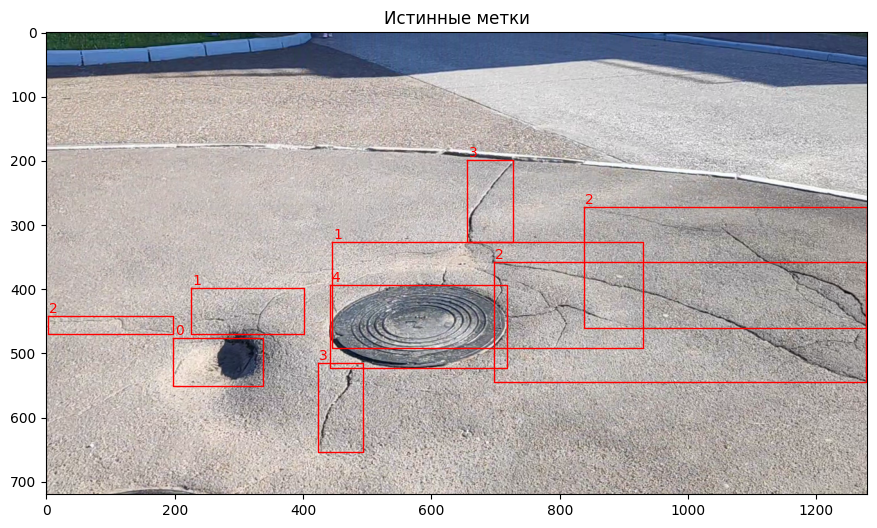

In [168]:
show_bboxes("2_img0001")

# Создаем файл data.yaml 

In [8]:
text = """train: images/train
val: images/val
nc: 5
names: 
- pothole
- crocodile cracking
- lateral cracking
- longitudinal cracking
- sewer manhole"""

with open("yolov8_dataset/data.yaml", "w") as f:
    for txt in text.split("\n"):
        f.write(txt + "\n")

In [9]:
!cat /kaggle/working/yolov8_dataset/data.yaml

train: images/train
val: images/val
nc: 5
names: 
- pothole
- crocodile cracking
- lateral cracking
- longitudinal cracking
- sewer manhole


# Дополнительные аугментации

In [8]:
train_transforms = A.Compose(
    [
        A.OneOf([
            A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared", 
                noise_params={"mean_range": [0, 0], "std_range": [0.01, 0.02]}, p=1),
            A.ISONoise(color_shift=(0.01, 0.05), intensity = (0.1, 0.2), p=1)
        ], p=0.15),
        A.CLAHE(clip_limit=(1, 2), p=0.3),
        A.OneOf([
            A.OneOf([
                A.Blur(blur_limit=(3, 3), p=1),
                A.MotionBlur(blur_limit=(3, 5), allow_shifted=True, p=1),
                A.MedianBlur(blur_limit=(3, 5), p=1)
            ], p=1),
            A.OneOf([
                A.ImageCompression(compression_type='jpeg', 
                    quality_range=(40, 70), p=1),
                A.Downscale(scale_range=(0.5, 0.7), 
                    interpolation_pair={'upscale': 0, 'downscale': 0}, p=1)
            ], p=1),
        ], p=0.05),
        A.OneOf([
            A.PlanckianJitter(mode='blackbody', temperature_limit=(6000, 10000), 
                sampling_method='uniform', p=1),
            A.ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), 
                saturation=(0.9, 1.1), hue=(-0.1, 0.1), p=1)
        ], p=0.5),
        A.OneOf([
            A.RandomRain(slant_range=(-15, 15), drop_length=10, drop_width=1, 
                drop_color=(200, 200, 200), blur_value=7, brightness_coefficient=0.8, 
                rain_type='default', p=1),
            A.OneOf([
                A.Spatter(gauss_sigma=(4, 6), mode="mud", p=1),
                A.Spatter(gauss_sigma=(4, 6), mode="rain", p=1)
            ], p=1)
        ], p=0.1),
        A.Sharpen(alpha=(0, 0.25), p=0.25)
    ], 
    bbox_params=A.BboxParams(
        format='yolo', 
        label_fields=['class_labels'],
        min_area=1.0,       
        min_width=1.0,      
        min_height=1.0  
    )
)

/usr/local/lib/python3.11/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [9]:
class SafeAlbumentationsWrapper:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, *args, **kwargs):
        kwargs.setdefault('bboxes', [])
        kwargs.setdefault('class_labels', [])

        return self.transform(**kwargs)

    
class CustomDetectionTrainer(DetectionTrainer):
    def __init__(self, *args, **kwargs):
        self.custom_transforms = kwargs.pop('custom_transforms', None)
        super().__init__(*args, **kwargs)
        if self.custom_transforms is None:
            raise ValueError("Кастомные трансформации не были переданы в тренер.")

    def build_dataset(self, img_path, mode='train', batch=None):
        dataset = super().build_dataset(img_path, mode=mode, batch=batch)

        if mode == 'train' and self.custom_transforms:
            for i, t in enumerate(dataset.transforms.transforms):
                if isinstance(t, UltralyticsAlbumentations):
                    t.transform = SafeAlbumentationsWrapper(self.custom_transforms)
                    print("-" * 40)
                    print("Трансформации успешно и безопасно внедрены!")
                    print("-" * 40)
                    break
        return dataset 

# Создание модели, обучение

In [10]:
DATA_YAML_PATH = 'yolov8_dataset/data.yaml'

In [11]:
model = YOLO("yolov8m.pt")
trainer_with_transforms = partial(CustomDetectionTrainer, custom_transforms=train_transforms)

In [12]:
train_args = {
    'data': DATA_YAML_PATH, 
    'epochs': 100, 
    'imgsz': 1024,
    'batch': 16, 
    'weight_decay': 0.001,
    'optimizer': 'AdamW',
    'device': 0, 
    'patience': 30, 
    'seed': 42, 
    'lr0': 0.0005, 
    'lrf': 0.05, 
    "cos_lr": True, 
    'close_mosaic': 10,
    'warmup_epochs': 3,
    'plots': True,
    'flipud': 0.0, 
    'fliplr': 0.5,
    'degrees': 7.0,
    'translate': 0.1,
    'scale': 0.4,
    'perspective': 0.0001,
    'mosaic': 0.95,
    'trainer': trainer_with_transforms,
    #'fraction': 0.01
    #'resume': True
}

In [ ]:
results = model.train(**train_args)

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/yolov8_dataset/data.yaml, degrees=7.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.05, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=0.95, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=30, perspective=0.0001, plots

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2793.1±974.1 MB/s, size: 687.4 KB)


train: Scanning /kaggle/working/yolov8_dataset/labels/train... 5512 images, 914 backgrounds, 0 corrupt: 100%|██████████| 5512/5512 [00:13<00:00, 396.33it/s] 

train: New cache created: /kaggle/working/yolov8_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
----------------------------------------
Трансформации успешно и безопасно внедрены!
----------------------------------------
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1687.1±1443.2 MB/s, size: 1008.0 KB)


val: Scanning /kaggle/working/yolov8_dataset/labels/val... 613 images, 111 backgrounds, 0 corrupt: 100%|██████████| 613/613 [00:01<00:00, 567.07it/s]

val: New cache created: /kaggle/working/yolov8_dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.001), 83 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      13.3G      2.098      3.142      1.905         22       1024: 100%|██████████| 345/345 [07:45<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


                   all        613       1120      0.304        0.3      0.218     0.0796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      12.3G      2.015      2.418      1.873         25       1024: 100%|██████████| 345/345 [07:42<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


                   all        613       1120      0.324      0.341      0.305      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      10.1G       1.99      2.384      1.862         23       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


                   all        613       1120      0.391      0.354      0.322      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      14.7G      1.971       2.32       1.85         20       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


                   all        613       1120      0.366      0.344      0.307      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.3G      1.925      2.216      1.809         40       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


                   all        613       1120      0.432      0.415      0.418      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.2G      1.894      2.147      1.783         20       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


                   all        613       1120      0.505      0.447      0.456      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      10.1G      1.874      2.094      1.781         18       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


                   all        613       1120      0.531      0.432      0.449      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      14.3G      1.848      2.055      1.742         18       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


                   all        613       1120      0.516      0.481      0.473      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      12.7G      1.813      1.981      1.731         23       1024: 100%|██████████| 345/345 [07:40<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


                   all        613       1120      0.518      0.462      0.473      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100        14G      1.822       1.96      1.723         18       1024: 100%|██████████| 345/345 [07:40<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


                   all        613       1120      0.504       0.48      0.483      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      10.1G      1.794      1.927      1.702          7       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


                   all        613       1120      0.555      0.534      0.534      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      13.3G      1.784       1.91      1.694         31       1024: 100%|██████████| 345/345 [07:40<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


                   all        613       1120      0.536      0.474      0.503      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      12.3G      1.762       1.85      1.677         12       1024: 100%|██████████| 345/345 [07:40<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


                   all        613       1120      0.542      0.518      0.534      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.8G      1.753      1.832      1.676         26       1024: 100%|██████████| 345/345 [07:40<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


                   all        613       1120      0.573      0.554      0.543      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      10.1G      1.723      1.803      1.658         31       1024: 100%|██████████| 345/345 [07:40<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


                   all        613       1120      0.561      0.549      0.572      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      13.8G      1.715      1.763      1.654         23       1024: 100%|██████████| 345/345 [07:42<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.54it/s]


                   all        613       1120      0.612      0.521      0.569      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      13.8G      1.718      1.754      1.646         23       1024: 100%|██████████| 345/345 [07:44<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


                   all        613       1120      0.574      0.575      0.563      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      12.6G      1.692      1.718      1.628         40       1024: 100%|██████████| 345/345 [07:44<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


                   all        613       1120      0.655      0.576      0.592      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      10.2G      1.685      1.684      1.628         27       1024: 100%|██████████| 345/345 [07:42<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


                   all        613       1120      0.569      0.579      0.586      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100        13G       1.68      1.661      1.623         32       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


                   all        613       1120      0.639      0.573        0.6      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      14.3G      1.682      1.643      1.618         16       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


                   all        613       1120      0.574      0.606      0.598      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100        14G      1.657      1.624      1.601         18       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


                   all        613       1120      0.617      0.606      0.623      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      10.1G      1.655      1.602        1.6         15       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


                   all        613       1120      0.595      0.599      0.605      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      13.7G      1.639      1.584      1.584         37       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


                   all        613       1120      0.614       0.58      0.608      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      12.8G      1.637      1.552      1.583         45       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


                   all        613       1120      0.617      0.586      0.613      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      13.3G      1.616      1.534       1.57         18       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


                   all        613       1120      0.651      0.578      0.627        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      10.1G      1.618      1.505      1.564         23       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


                   all        613       1120       0.64      0.592      0.604      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      14.3G      1.603      1.472      1.554         29       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


                   all        613       1120      0.632       0.63      0.643      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      13.2G      1.593      1.459      1.547         25       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


                   all        613       1120      0.648      0.622      0.648       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      13.6G      1.588      1.447      1.548         32       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


                   all        613       1120      0.699      0.616      0.662      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      10.1G      1.578      1.416      1.541         33       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


                   all        613       1120      0.657      0.646      0.665      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100        13G      1.569      1.392       1.53         23       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.54it/s]


                   all        613       1120      0.647      0.645      0.666      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      13.2G      1.565      1.385       1.52         34       1024: 100%|██████████| 345/345 [07:42<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


                   all        613       1120      0.659      0.633      0.656      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      13.1G      1.538      1.344      1.506         18       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


                   all        613       1120      0.662      0.645      0.671      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      10.1G      1.537      1.345      1.507         30       1024: 100%|██████████| 345/345 [07:42<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


                   all        613       1120      0.702      0.647      0.683      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      14.2G      1.531      1.327      1.501         30       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


                   all        613       1120      0.691       0.66      0.685      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      13.2G      1.522        1.3      1.498         45       1024: 100%|██████████| 345/345 [07:42<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


                   all        613       1120      0.687      0.666      0.688      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      13.6G      1.509      1.281      1.481         37       1024: 100%|██████████| 345/345 [07:42<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


                   all        613       1120      0.685      0.647      0.677      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      10.1G      1.494      1.258      1.467          4       1024: 100%|██████████| 345/345 [07:43<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


                   all        613       1120      0.725       0.64      0.694      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      13.8G      1.488      1.258      1.467         31       1024: 100%|██████████| 345/345 [07:43<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


                   all        613       1120      0.687      0.652      0.676      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      12.8G      1.478      1.235       1.46         33       1024: 100%|██████████| 345/345 [07:42<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


                   all        613       1120      0.672      0.638      0.671      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      13.2G      1.474      1.205      1.452         40       1024: 100%|██████████| 345/345 [07:42<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.54it/s]


                   all        613       1120      0.699      0.662      0.696      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      10.2G      1.457      1.194      1.449         15       1024: 100%|██████████| 345/345 [07:42<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]

                   all        613       1120      0.677      0.662      0.688      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      13.8G      1.455      1.175      1.445         21       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]

                   all        613       1120      0.695       0.68      0.688      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      13.6G       1.43      1.145       1.42         35       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.681      0.679      0.704      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      13.2G      1.444      1.168      1.435         30       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120       0.68      0.686      0.703      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      10.1G      1.428      1.131      1.422         26       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.707      0.674      0.711      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      13.4G      1.412      1.115      1.412         15       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


                   all        613       1120      0.713       0.63      0.691      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      13.1G      1.412      1.105      1.408         16       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]

                   all        613       1120      0.708      0.651      0.697      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      13.6G      1.399      1.086      1.405         24       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]

                   all        613       1120      0.675      0.698      0.709      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      10.1G      1.383      1.063      1.395         32       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]

                   all        613       1120      0.701      0.654      0.698      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      14.2G      1.372      1.037      1.381         25       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


                   all        613       1120      0.719      0.677      0.716       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      14.1G      1.355      1.035      1.373         25       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120       0.72      0.651      0.708      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100        13G      1.352      1.011      1.364         17       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]

                   all        613       1120      0.732      0.685      0.715      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      10.1G       1.35      1.014      1.368         27       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.739      0.644      0.701       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      13.8G      1.336     0.9898      1.354         20       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


                   all        613       1120      0.733      0.662      0.703      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      13.8G      1.331     0.9878      1.348         26       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


                   all        613       1120      0.704      0.683      0.714      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      13.1G      1.329     0.9877      1.348         20       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


                   all        613       1120      0.748      0.675      0.715      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      10.1G      1.305     0.9506      1.329         36       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]

                   all        613       1120      0.696      0.692      0.714       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      12.9G      1.288      0.943       1.32         28       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.709      0.682      0.709      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      13.3G      1.289     0.9195      1.318         20       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.729      0.677      0.719      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100        14G      1.275     0.9128      1.314         48       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]

                   all        613       1120       0.75       0.66      0.727      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      10.1G      1.273     0.9085      1.302         23       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]

                   all        613       1120       0.73       0.69      0.727      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      13.8G      1.258     0.8927      1.294         21       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.743      0.661      0.719      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100        12G      1.242     0.8805      1.287         23       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]

                   all        613       1120       0.74      0.681      0.721       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      14.1G       1.24     0.8608      1.277         25       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.715      0.698       0.72      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      10.1G      1.229     0.8631      1.276         29       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


                   all        613       1120      0.757      0.678      0.729      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      14.3G      1.225     0.8547      1.272         19       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]

                   all        613       1120      0.722      0.697      0.722      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      13.7G      1.212     0.8451      1.264         34       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.738      0.674      0.726      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      12.6G      1.211     0.8338      1.262         28       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]

                   all        613       1120      0.743      0.673      0.728      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      10.1G      1.198     0.8264      1.249         25       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.761      0.663      0.724      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      13.7G      1.194     0.8209      1.251         26       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]

                   all        613       1120      0.746      0.683      0.731      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      12.8G      1.181     0.8072      1.243         31       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.721      0.691      0.724      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      13.8G      1.172      0.804      1.235         29       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.747      0.681      0.724      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      10.2G       1.16     0.7834      1.236         31       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.765      0.662      0.727      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      13.8G      1.157     0.7852      1.229         29       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]

                   all        613       1120      0.772      0.665      0.726      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      13.2G      1.151     0.7892      1.225         18       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]

                   all        613       1120      0.753      0.673      0.722      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      13.6G      1.142     0.7731      1.221         18       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]

                   all        613       1120      0.784      0.658      0.731      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      10.3G      1.138     0.7673      1.209         25       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.764      0.653      0.721      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      15.1G      1.131     0.7601      1.208         21       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.762      0.656      0.718      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      13.7G      1.121     0.7564      1.206         17       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]

                   all        613       1120      0.748      0.673      0.717      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      13.2G      1.116     0.7554      1.195         20       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.762      0.661      0.717      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      10.2G      1.107     0.7359      1.193         32       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]

                   all        613       1120      0.746      0.667      0.715      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      14.3G      1.113     0.7479      1.196         22       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.735      0.659      0.712      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      13.2G        1.1     0.7334      1.189         28       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.58it/s]

                   all        613       1120      0.719      0.698      0.723      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      14.4G      1.095     0.7369      1.183         36       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]

                   all        613       1120       0.75      0.661      0.717      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      10.1G      1.088     0.7299      1.189         21       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


                   all        613       1120      0.757      0.672      0.716      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      14.5G      1.072     0.7127      1.176         21       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.763      0.669       0.72      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      14.7G       1.08     0.7203      1.179         32       1024: 100%|██████████| 345/345 [07:40<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.758      0.665      0.717      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      14.7G      1.071     0.7236      1.171         41       1024:  24%|██▍       | 82/345 [01:49<05:51,  1.34s/it]

In [13]:
model = YOLO("/kaggle/input/yolov8_last/pytorch/default/1/last.pt")

In [14]:
train_args = {
    'data': DATA_YAML_PATH, 
    'epochs': 100, 
    'imgsz': 1024,
    'batch': 16, 
    'weight_decay': 0.001,
    'optimizer': 'AdamW',
    'device': 0, 
    'patience': 30, 
    'seed': 42, 
    'lr0': 0.0005, 
    'lrf': 0.05, 
    "cos_lr": True, 
    'close_mosaic': 10,
    'warmup_epochs': 3,
    'plots': True,
    'flipud': 0.0, 
    'fliplr': 0.5,
    'degrees': 7.0,
    'translate': 0.1,
    'scale': 0.4,
    'perspective': 0.0001,
    'mosaic': 0.95,
    'trainer': trainer_with_transforms,
    #'fraction': 0.01
    'resume': True
}

In [15]:
results = model.train(**train_args)

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/yolov8_dataset/data.yaml, degrees=7.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.05, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/yolov8_last/pytorch/default/1/last.pt, momentum=0.937, mosaic=0.95, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=Tru


                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2900.7±1042.5 MB/s, size: 687.4 KB)


train: Scanning /kaggle/working/yolov8_dataset/labels/train... 5512 images, 914 backgrounds, 0 corrupt: 100%|██████████| 5512/5512 [00:13<00:00, 403.02it/s] 


train: New cache created: /kaggle/working/yolov8_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
----------------------------------------
Трансформации успешно и безопасно внедрены!
----------------------------------------
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1826.1±1570.0 MB/s, size: 1008.0 KB)


val: Scanning /kaggle/working/yolov8_dataset/labels/val... 613 images, 111 backgrounds, 0 corrupt: 100%|██████████| 613/613 [00:01<00:00, 510.01it/s]

val: New cache created: /kaggle/working/yolov8_dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.001), 83 bias(decay=0.0)
Resuming training /kaggle/input/yolov8_last/pytorch/default/1/last.pt from epoch 90 to 100 total epochs
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      12.3G      1.081     0.7267       1.18         22       1024: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]

                   all        613       1120      0.746      0.667      0.714       0.37


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      9.65G      1.005     0.5814      1.139         14       1024: 100%|██████████| 345/345 [07:42<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]

                   all        613       1120      0.731      0.679      0.708      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      12.1G     0.9806     0.5592      1.129          7       1024: 100%|██████████| 345/345 [07:40<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]

                   all        613       1120      0.744      0.666      0.714      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      13.8G     0.9662     0.5497      1.119         17       1024: 100%|██████████| 345/345 [07:40<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]

                   all        613       1120      0.741       0.68      0.712      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      13.6G     0.9488     0.5358      1.109         13       1024: 100%|██████████| 345/345 [07:40<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]

                   all        613       1120      0.734      0.684      0.715      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      9.66G      0.947     0.5407      1.112         13       1024: 100%|██████████| 345/345 [07:40<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]

                   all        613       1120      0.761      0.663      0.715      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      13.5G     0.9498      0.542      1.106         15       1024: 100%|██████████| 345/345 [07:40<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120       0.75      0.675      0.716      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      13.1G     0.9396     0.5329      1.106         18       1024: 100%|██████████| 345/345 [07:40<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.739      0.689      0.718      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      13.1G     0.9309     0.5218      1.101         21       1024: 100%|██████████| 345/345 [07:40<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120       0.73      0.692      0.719      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      9.65G     0.9304     0.5199      1.094         15       1024: 100%|██████████| 345/345 [07:39<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]

                   all        613       1120      0.757      0.666      0.719      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      13.4G     0.9272     0.5204      1.095         16       1024: 100%|██████████| 345/345 [07:39<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]

                   all        613       1120      0.713       0.71      0.717       0.37



11 epochs completed in 1.449 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.1MB


In [9]:
model = YOLO("/kaggle/input/yolo_model/pytorch/default/1/yolo_best_model.pt")

In [56]:
import logging
import warnings

logging.getLogger("ultralytics").setLevel(logging.WARNING)
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in less")

# Отбор гиперпараметров conf и iou для получения лучшего качества

In [62]:
best_metric = 0
best_conf = -1
best_iou = -1

conf_list = [0.1, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3]
iou_list = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

print("==="*13)
for conf in conf_list:
    for iou in iou_list:
        metrics = model.val(
            data=DATA_YAML_PATH,
            imgsz=1024,
            batch=16,
            conf=conf,
            iou=iou,
            device="0",
            verbose=False
        )

        metric1 = metrics.results_dict[f"metrics/precision(B)"]
        metric2 = metrics.results_dict[f"metrics/recall(B)"]
        metric3 = metrics.results_dict[f"metrics/mAP50(B)"]
        metric = 0.2 * metric1 + 0.5 * metric2 + 0.3 * metric3

        if metric > best_metric:
            best_metric = metric
            best_conf = conf
            best_iou = iou
        
        print(f"conf={conf:.3f}, iou={iou:.3f} | metric = {metric:.3f}")
        print("==="*13)

print()
print(f"Оптимальные параметры: conf={best_conf:.3f}, iou={best_iou:.3f}")
print(f"Лучшее значение метрики: {best_metric:.3f}")

conf=0.100, iou=0.200 | metric = 0.714
conf=0.100, iou=0.250 | metric = 0.714
conf=0.100, iou=0.300 | metric = 0.716
conf=0.100, iou=0.350 | metric = 0.717
conf=0.100, iou=0.400 | metric = 0.718
conf=0.100, iou=0.450 | metric = 0.720
conf=0.100, iou=0.500 | metric = 0.719
conf=0.150, iou=0.200 | metric = 0.713
conf=0.150, iou=0.250 | metric = 0.713
conf=0.150, iou=0.300 | metric = 0.716
conf=0.150, iou=0.350 | metric = 0.717
conf=0.150, iou=0.400 | metric = 0.717
conf=0.150, iou=0.450 | metric = 0.719
conf=0.150, iou=0.500 | metric = 0.718
conf=0.175, iou=0.200 | metric = 0.713
conf=0.175, iou=0.250 | metric = 0.712
conf=0.175, iou=0.300 | metric = 0.714
conf=0.175, iou=0.350 | metric = 0.715
conf=0.175, iou=0.400 | metric = 0.716
conf=0.175, iou=0.450 | metric = 0.718
conf=0.175, iou=0.500 | metric = 0.717
conf=0.200, iou=0.200 | metric = 0.712
conf=0.200, iou=0.250 | metric = 0.713
conf=0.200, iou=0.300 | metric = 0.717
conf=0.200, iou=0.350 | metric = 0.717
conf=0.200, iou=0.400 | m

# Лучшие метрики качества: `mAP[.5]=0.733`, `mAP[.5:.95]=0.405`

In [63]:
logging.getLogger("ultralytics").setLevel(logging.INFO)
metrics = model.val(data=DATA_YAML_PATH, imgsz=1024, batch=16, conf=0.2, iou=0.450, device="0")

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3313.1±1786.2 MB/s, size: 822.7 KB)


val: Scanning /kaggle/working/yolov8_dataset/labels/val.cache... 613 images, 111 backgrounds, 0 corrupt: 100%|██████████| 613/613 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:14<00:00,  2.74it/s]


                   all        613       1120      0.702      0.722      0.733      0.405
               pothole        144        286      0.786      0.759      0.804      0.433
    crocodile cracking        116        136      0.676      0.743      0.756      0.426
      lateral cracking        164        249      0.554      0.574      0.533      0.209
 longitudinal cracking        230        378      0.607      0.662      0.656      0.389
         sewer manhole         52         71      0.885      0.873      0.917      0.569
Speed: 1.1ms preprocess, 17.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val75


In [65]:
def show_image_preds(indx):
    image = cv2.imread(img[indx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(image)
    plt.title("Предсказание модели")
    for box, label in zip(pred[indx].boxes.xyxy, pred[indx].boxes.cls):
        bbox(box.cpu(), int(label.cpu().item()))

## Оценка скорости инференса модели на `CPU` и `GPU`

In [32]:
%%time
img = ["yolov8_dataset/images/val/12_img018.png"]
pred = model.predict(img, imgsz=1024, conf=0.2, iou=0.450, verbose=False)

CPU times: user 122 ms, sys: 0 ns, total: 122 ms
Wall time: 120 ms


In [33]:
model = model.to("cpu")

In [35]:
%%time
img = ["yolov8_dataset/images/val/12_img018.png"]
pred = model.predict(img, imgsz=1024, conf=0.2, iou=0.450, verbose=False)

CPU times: user 1.34 s, sys: 126 ms, total: 1.47 s
Wall time: 778 ms


# Визуализация предсказаний

In [147]:
img = ["yolov8_dataset/images/val/12_img018.png", 
       "yolov8_dataset/images/val/3_img0031.png"]

pred = model.predict(img, imgsz=1024, conf=0.2, iou=0.450)


0: 1024x1024 1 pothole, 30.1ms
1: 1024x1024 2 sewer manholes, 30.1ms
Speed: 5.7ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)


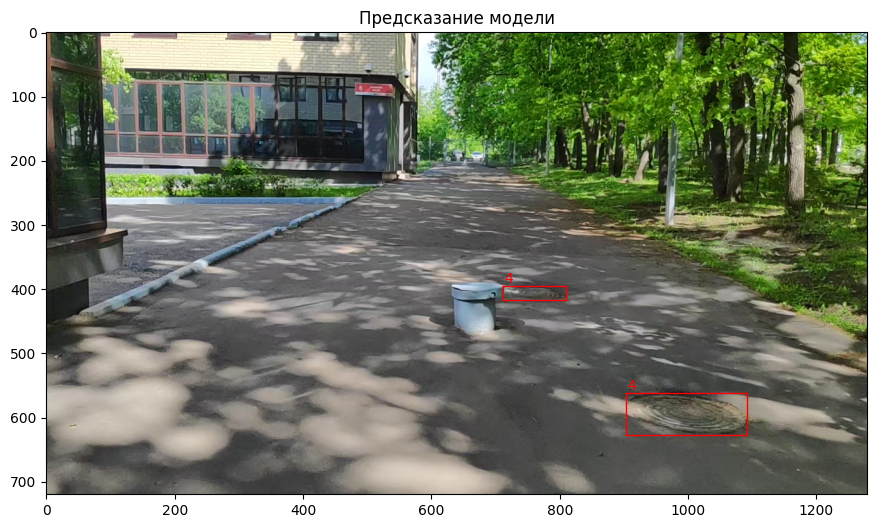

In [148]:
show_image_preds(1)

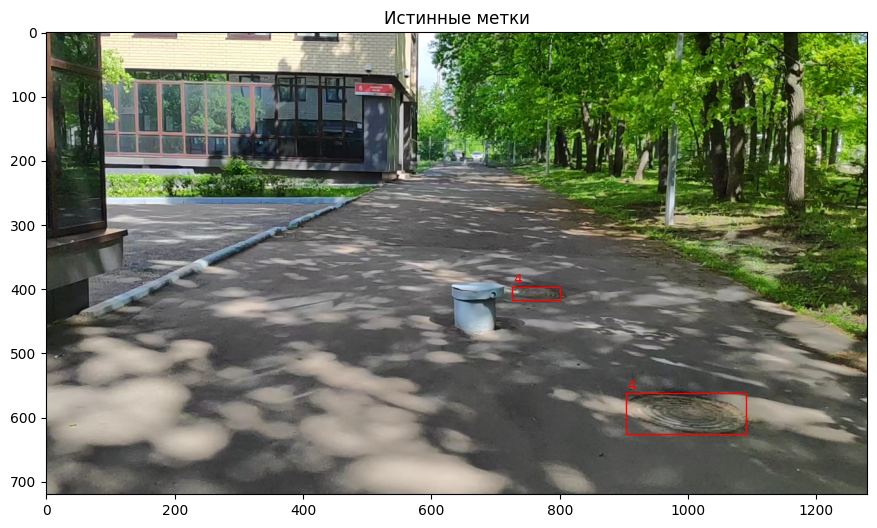

In [149]:
show_bboxes("3_img0031", folder="val")

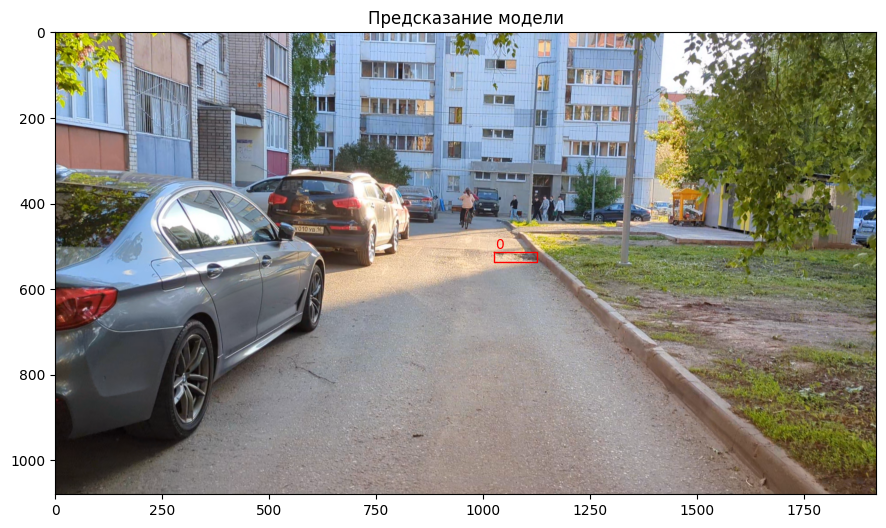

In [150]:
show_image_preds(0)

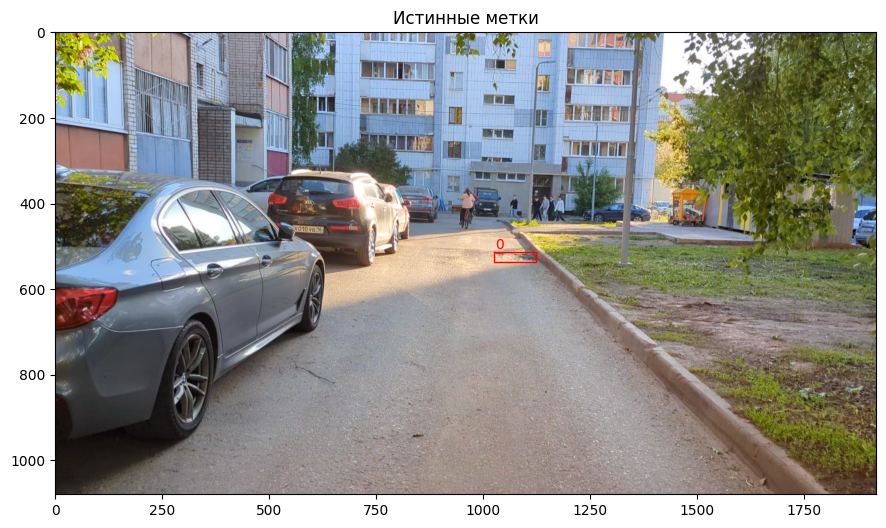

In [152]:
show_bboxes("12_img018", folder="val")